In [1]:
from obspy import read
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft

%matplotlib inline

In [2]:
st1 = read('data/earthquake/st1.SAC')
st2 = read('data/earthquake/st2.SAC')
st3 = read('data/earthquake/st3.SAC')

threechannels = read('data/earthquake/st1.SAC')
threechannels += read('data/earthquake/st2.SAC')
threechannels += read('data/earthquake/st3.SAC')

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


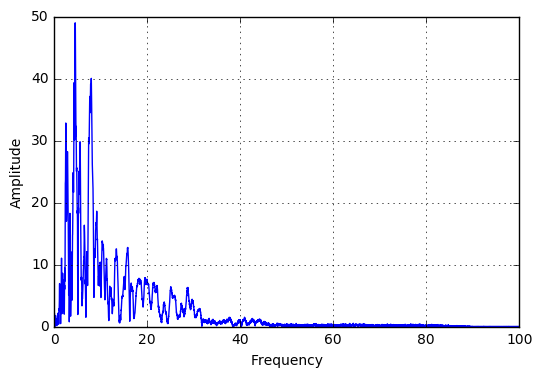

In [3]:
data=st3[0].data
# Number of samplepoints
N = st3[0].stats.npts
# sample spacing
T = 1/st3[0].stats.sampling_rate

x = np.linspace(0.0, N*T, N)
y = data
yf = fft(y)
xf = np.linspace(0.0, 1.0/(2.0*T), N/2)
import matplotlib.pyplot as plt
plt.plot(xf, 2.0/N * np.abs(yf[0:N/2]))
plt.grid()
plt.ylabel('Amplitude')
plt.xlabel('Frequency')

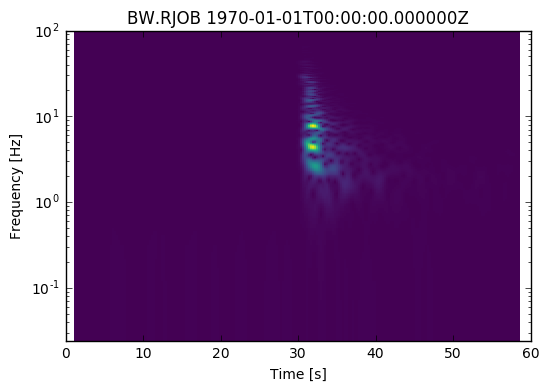

[None]

In [4]:
st3.spectrogram(log=True, title='BW.RJOB ' + str(st3[0].stats.starttime))

In [7]:
# -*- coding: utf-8 -*-
# ------------------------------------------------------------------
# Filename: spectrogram.py
#  Purpose: Plotting spectrogram of Seismograms.
#   Author: Christian Sippl, Moritz Beyreuther
#    Email: sippl@geophysik.uni-muenchen.de
#
# Copyright (C) 2008-2012 Christian Sippl
# --------------------------------------------------------------------
"""
Plotting spectrogram of seismograms.

:copyright:
    The ObsPy Development Team (devs@obspy.org)
:license:
    GNU Lesser General Public License, Version 3
    (https://www.gnu.org/copyleft/lesser.html)
"""
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
from future.builtins import *  # NOQA @UnusedWildImport

import math as M

import numpy as np
from matplotlib import mlab
from matplotlib.colors import Normalize

from obspy.imaging.cm import obspy_sequential


def _nearest_pow_2(x):
    """
    Find power of two nearest to x

    >>> _nearest_pow_2(3)
    2.0
    >>> _nearest_pow_2(15)
    16.0

    :type x: float
    :param x: Number
    :rtype: Int
    :return: Nearest power of 2 to x
    """
    a = M.pow(2, M.ceil(np.log2(x)))
    b = M.pow(2, M.floor(np.log2(x)))
    if abs(a - x) < abs(b - x):
        return a
    else:
        return b


def spectrogram(data, samp_rate, per_lap=0.9, wlen=None, log=False,
                outfile=None, fmt=None, axes=None, dbscale=False,
                mult=8.0, cmap=obspy_sequential, zorder=None, title=None,
                show=True, sphinx=False, clip=[0.0, 1.0]):
    """
    Computes and plots spectrogram of the input data.

    :param data: Input data
    :type samp_rate: float
    :param samp_rate: Samplerate in Hz
    :type per_lap: float
    :param per_lap: Percentage of overlap of sliding window, ranging from 0
        to 1. High overlaps take a long time to compute.
    :type wlen: int or float
    :param wlen: Window length for fft in seconds. If this parameter is too
        small, the calculation will take forever.
    :type log: bool
    :param log: Logarithmic frequency axis if True, linear frequency axis
        otherwise.
    :type outfile: str
    :param outfile: String for the filename of output file, if None
        interactive plotting is activated.
    :type fmt: str
    :param fmt: Format of image to save
    :type axes: :class:`matplotlib.axes.Axes`
    :param axes: Plot into given axes, this deactivates the fmt and
        outfile option.
    :type dbscale: bool
    :param dbscale: If True 10 * log10 of color values is taken, if False the
        sqrt is taken.
    :type mult: float
    :param mult: Pad zeros to length mult * wlen. This will make the
        spectrogram smoother.
    :type cmap: :class:`matplotlib.colors.Colormap`
    :param cmap: Specify a custom colormap instance. If not specified, then the
        default ObsPy sequential colormap is used.
    :type zorder: float
    :param zorder: Specify the zorder of the plot. Only of importance if other
        plots in the same axes are executed.
    :type title: str
    :param title: Set the plot title
    :type show: bool
    :param show: Do not call `plt.show()` at end of routine. That way, further
        modifications can be done to the figure before showing it.
    :type sphinx: bool
    :param sphinx: Internal flag used for API doc generation, default False
    :type clip: [float, float]
    :param clip: adjust colormap to clip at lower and/or upper end. The given
        percentages of the amplitude range (linear or logarithmic depending
        on option `dbscale`) are clipped.
    """
    import matplotlib.pyplot as plt
    # enforce float for samp_rate
    samp_rate = float(samp_rate)

    # set wlen from samp_rate if not specified otherwise
    if not wlen:
        wlen = samp_rate / 100.

    npts = len(data)
    # nfft needs to be an integer, otherwise a deprecation will be raised
    # XXX add condition for too many windows => calculation takes for ever
    nfft = int(_nearest_pow_2(wlen * samp_rate))
    if nfft > npts:
        nfft = int(_nearest_pow_2(npts / 8.0))

    if mult is not None:
        mult = int(_nearest_pow_2(mult))
        mult = mult * nfft
    nlap = int(nfft * float(per_lap))

    data = data - data.mean()
    end = npts / samp_rate

    # Here we call not plt.specgram as this already produces a plot
    # matplotlib.mlab.specgram should be faster as it computes only the
    # arrays
    # XXX mlab.specgram uses fft, would be better and faster use rfft
    specgram, freq, time = mlab.specgram(data, Fs=samp_rate, NFFT=nfft,
                                         pad_to=mult, noverlap=nlap)
    # db scale and remove zero/offset for amplitude
    if dbscale:
        specgram = 10 * np.log10(specgram[1:, :])
    else:
        specgram = np.sqrt(specgram[1:, :])
    freq = freq[1:]

    vmin, vmax = clip
    if vmin < 0 or vmax > 1 or vmin >= vmax:
        msg = "Invalid parameters for clip option."
        raise ValueError(msg)
    _range = float(specgram.max() - specgram.min())
    vmin = specgram.min() + vmin * _range
    vmax = specgram.min() + vmax * _range
    norm = Normalize(vmin, vmax, clip=True)

    if not axes:
        fig = plt.figure()
        ax = fig.add_subplot(111)
    else:
        ax = axes

    # calculate half bin width
    halfbin_time = (time[1] - time[0]) / 2.0
    halfbin_freq = (freq[1] - freq[0]) / 2.0

    # argument None is not allowed for kwargs on matplotlib python 3.3
    kwargs = {k: v for k, v in (('cmap', cmap), ('zorder', zorder))
              if v is not None}

    if log:
        # pcolor expects one bin more at the right end
        freq = np.concatenate((freq, [freq[-1] + 2 * halfbin_freq]))
        time = np.concatenate((time, [time[-1] + 2 * halfbin_time]))
        # center bin
        time -= halfbin_time
        freq -= halfbin_freq
        # Log scaling for frequency values (y-axis)
        ax.set_yscale('log')
        # Plot times
        ax.pcolormesh(time, freq, specgram, norm=norm, **kwargs)
    else:
        # this method is much much faster!
        specgram = np.flipud(specgram)
        # center bin
        extent = (time[0] - halfbin_time, time[-1] + halfbin_time,
                  freq[0] - halfbin_freq, freq[-1] + halfbin_freq)
        ax.imshow(specgram, interpolation="nearest", extent=extent, **kwargs)

    # set correct way of axis, whitespace before and after with window
    # length
    ax.axis('tight')
    ax.set_xlim(0, end)
    ax.grid(False)

    if axes:
        return ax

    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Frequency [Hz]')
    if title:
        ax.set_title(title)

    if not sphinx:
        # ignoring all NumPy warnings during plot
        temp = np.geterr()
        np.seterr(all='ignore')
        plt.draw()
        np.seterr(**temp)
    if outfile:
        if fmt:
            fig.savefig(outfile, format=fmt)
        else:
            fig.savefig(outfile)
    elif show:
        plt.show()
    else:
        return fig

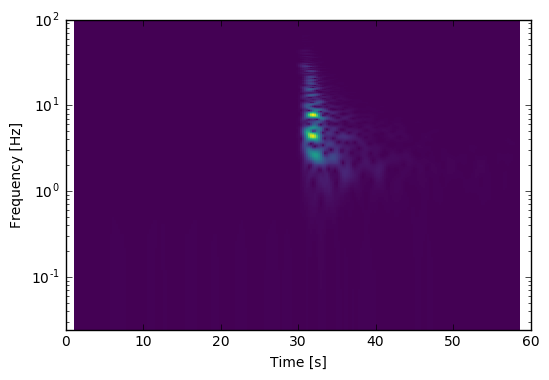

In [13]:
spectrogram(data,1/T,log='True')

In [8]:
1/T

200.0